In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('data/data_clean.csv')
df.head(1)

,kw,rank,link,success,word_count,percent_human,percent_ai
0,how to finish concrete,1,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917


In [4]:
def multiplot_dark(df, filter_col=None, min=None, max=None):
    # define subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    # Set background color to white
    plt.style.use('default')
    
    # apply filter and subtitle
    if filter_col:
        if min is not None and max is not None:
            if min < max:
                fig.text(0.5, 0.94, f'Filtered on {min} < {filter_col} < {max}', ha='center', fontsize=16)
                df = df[(df[filter_col] <= max) & (df[filter_col] >= min)]
            else:
                min, max = max, min
                fig.text(0.5, 0.94, f'Filtered on {min} > {filter_col} > {max}', ha='center', fontsize=16)
                df = df[(df[filter_col] >= max) | (df[filter_col] <= min)]
        elif min is not None and max is None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} > {min}', ha='center', fontsize=16)
            df = df[df[filter_col] >= min]
        elif min is None and max is not None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} < {max}', ha='center', fontsize=16)
            df = df[df[filter_col] <= max]
        else:
            print(f'Warning: you must provide a min and/or max on which to filter on {filter_col} or no filtering will occur')

    # apply main title
    main_title = f'Correlation Study: Rank vs Percent Human ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98)
    
    
    # Fig 1: Q-Q plot [0, 0]
    st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    axs[0, 0].set_title('Figure 1: Q-Q Plot of Percent Human', fontsize=16)
    axs[0, 0].set_xlabel('Theoretical quantiles', fontsize=14)
    axs[0, 0].set_ylabel('Sample quantiles', fontsize=14)
    axs[0, 0].text(0.02, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # Fig 2: Histogram [0, 1]
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color='green', ax=axs[0, 1])
    axs[0, 1].set_title('Figure 2: Histogram of Percent Human', fontsize=16)
    axs[0, 1].set_xlabel('Percent Human', fontsize=14)
    axs[0, 1].set_ylabel('Count', fontsize=14)
    axs[0, 1].set_xlim(-5, 105)
    axs[0, 1].set_ylim(0, None)
    skewness = round(st.skew(df['percent_human']),2)
    axs[0, 1].text(0.02, 0.95, f'Data Skewness {skewness}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')
    #axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # Fig 3: Violin plot [1, 0]
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y="percent_human", scale="count", inner="box", color="#00aa00", saturation=0.5, cut=0, linewidth=.9)

        # plot mean lines
    for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color='#444444', zorder=100)

        # plot median markers
    median_markers = df.groupby('rank')['percent_human'].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color='white', edgecolor='black', zorder=100)
    
    axs[1, 0].set_title('Fig 3:Percent Human vs Rank', fontsize=16)
    #axs[1, 0].set_facecolor('#ffffff')
    axs[1, 0].set_xlabel("Rank", fontsize=14)
    axs[1, 0].set_ylabel("Percent Human", fontsize=14)

   
    # Fig 4: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color='green')
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color='green', scatter=False, line_kws={'linestyle':'--'})
    axs[1, 1].set_title('Figure 4: Scatter Plot of Mean Percent Human vs Rank', fontsize=16)
    axs[1, 1].set_xlabel('Rank', fontsize=14)
    axs[1, 1].set_ylabel('Mean Percent Human', fontsize=14)
    axs[1, 1].set_xticks(np.arange(1, 21))
    axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'])
    axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color='black')

        # Calculate correlation coefficients and p-values
    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

        # Create a dictionary to store the results
    corr = {
        'Method': ['Point Biserial', 'Spearman', 'Kendall'],
        'Correlation Coefficient': [pb_corr, spearman_corr, kendall_tau],
        'P-value': [pb_pval, spearman_pval, kendall_pval]
    }

        # Create a pandas dataframe from the corr dict
    df_corr = pd.DataFrame(corr)

        # Create a table to display the correlation coefficients and p-values
    col_labels = ['Method', 'Corr Coef', 'P-value']
    table_data = [col_labels] + df_corr.values.tolist()

    table = axs[1, 1].table(cellText=table_data,
                    colLabels=None,
                    cellLoc='center',
                    bbox=[0.02, 0.08, 0.5, 0.15])  # x, y, width, height
    table.set_fontsize(10)

        # Format the table to use 4 significant figures
    for i in range(1, len(table_data)):
        for j in range(1, 3):
            cell = table.get_celld()[i, j]
            cell_text = cell.get_text().get_text()
            cell_text = float(cell_text)
            cell_text = f'{cell_text:.4g}'
            cell.get_text().set_text(cell_text)

    # shrink outer margin
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
   
    fig.savefig('figures/Fig_1-4.png')
    plt.show()

In [5]:
def multiplotv_dark(df: pd.DataFrame, filter_col: str = None, fmin: float = None, fmax: float = None) -> None:
    """
    Generate a set of 4 plots to visualize the relationship between two variables in a DataFrame.
    :param df: DataFrame containing the data
    :param filter_col: Name of the column to filter on (optional)
    :param filter_min: Minimum value for the filter_col (optional)
    :param filter_max: Maximum value for the filter_col (optional)
    """

    # define subplots
    face_color = '0.1'
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=face_color)
    
    # Set background color to black
    #plt.style.use('dark_background')

    # apply filter and subtitle
    if filter_col:
        if fmin is not None and fmax is not None:
            if fmin < fmax:
                fig.text(0.5, 0.94, f'Filtered on {fmin} < {filter_col} < {fmax}', ha='center', fontsize=16, color='white')
                df = df[(df[filter_col] <= fmax) & (df[filter_col] >= fmin)]
            else:
                fmin, fmax = fmax, fmin
                fig.text(0.5, 0.94, f'Filtered on {fmin} > {filter_col} > {fmax}', ha='center', fontsize=16, color='white')
                df = df[(df[filter_col] >= fmax) | (df[filter_col] <= fmin)]
        elif fmin is not None and fmax is None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} > {fmin}', ha='center', fontsize=16, color='white')
            df = df[df[filter_col] >= fmin]
        elif fmin is None and fmax is not None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} < {fmax}', ha='center', fontsize=16, color='white')
            df = df[df[filter_col] <= fmax]
        else:
            print(f'Warning: you must provide a min and/or max on which to filter on {filter_col} or no filtering will occur')

    # apply main title
    main_title = f'Correlation Study: Rank vs Percent Human ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98, color='white')
    
    
    # Fig 1: Q-Q plot [0, 0]
    st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    axs[0, 0].set_title('Figure 1: Q-Q Plot of Percent Human')
    axs[0, 0].set_xlabel('Theoretical quantiles')
    axs[0, 0].set_ylabel('Sample quantiles')
    axs[0, 0].text(0.02, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='white')

    
    # Fig 2: Histogram [0, 1]
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color='green', ax=axs[0, 1], edgecolor='grey')
    axs[0, 1].set_title('Figure 2: Histogram of Percent Human')
    axs[0, 1].set_xlabel('Percent Human')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlim(-5, 105)
    axs[0, 1].set_ylim(0, None)
    skewness = round(st.skew(df['percent_human']), 2)
    axs[0, 1].text(0.02, 0.95, f'Data Skewness {skewness}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='white')
    #axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # Fig 3: Violin plot [1, 0]
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y="percent_human", scale="count", inner="box", color="#00aa00", saturation=0.5, cut=0, linewidth=.9)

        # plot mean lines
    for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color='#bbbbbb', zorder=100)

        # plot median markers
    median_markers = df.groupby('rank')['percent_human'].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color='white', edgecolor='black', zorder=100)
    
    axs[1, 0].set_title('Figure 3: Percent Human vs Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel('Percent Human')

   
    # Fig 4: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color='green', edgecolor=None)
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color='green', scatter=False, line_kws={'linestyle':'--'})
    axs[1, 1].set_title('Figure 4: Mean Percent Human vs Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel('Mean Percent Human')
    axs[1, 1].set_xticks(np.arange(1, 21))
    axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'], facecolor=face_color, labelcolor='white')
    axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color='white')

        # Calculate correlation coefficients and p-values
    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

        # Create a dictionary to store the results
    corr = {
        'Method': ['Point Biserial', 'Spearman', 'Kendall'],
        'Corr Coef': [pb_corr, spearman_corr, kendall_tau],
        'P-value': [pb_pval, spearman_pval, kendall_pval]
    }

        # Create a pandas dataframe from the corr dict
    df_corr = pd.DataFrame(corr)

        # Create a table to display the correlation coefficients and p-values
    table_data = [list(df_corr.columns)] + df_corr.values.tolist()
    table = axs[1, 1].table(cellText=table_data,
                    colLabels=None,
                    cellLoc='center',
                    bbox=[0.02, 0.08, 0.5, 0.15],  # x, y, width, height
                    cellColours=[[face_color]*3] + [[face_color]*3]*len(df_corr))
    table.set_fontsize(10)
    for cell in table.get_celld().values():
        cell.set_linewidth(0)
        cell.set_edgecolor('none')
        cell.set_text_props(color='white')


        # Format the table to use 4 significant figures
    for i in range(1, len(table_data)):
        for j in range(1, 3):
            cell = table.get_celld()[i, j]
            cell_text = cell.get_text().get_text()
            cell_text = float(cell_text)
            cell_text = f'{cell_text:.4g}'
            cell.get_text().set_text(cell_text)
            #cell.set_edgecolor('white')
    
    font_color = '#cccccc'
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=12, colors=font_color)
        ax.tick_params(axis='y', labelsize=12, colors=font_color)
        ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': font_color})
        ax.set_ylabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': font_color})
        ax.set_title(ax.get_title(), fontdict={'fontsize': 16, 'color': 'white'})
        ax.set_facecolor(face_color)
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
            #spine.set_linewidth(2)
    
    # shrink outer margin
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
   
    fig.savefig('figures/Fig_1-4.png')
    plt.show()

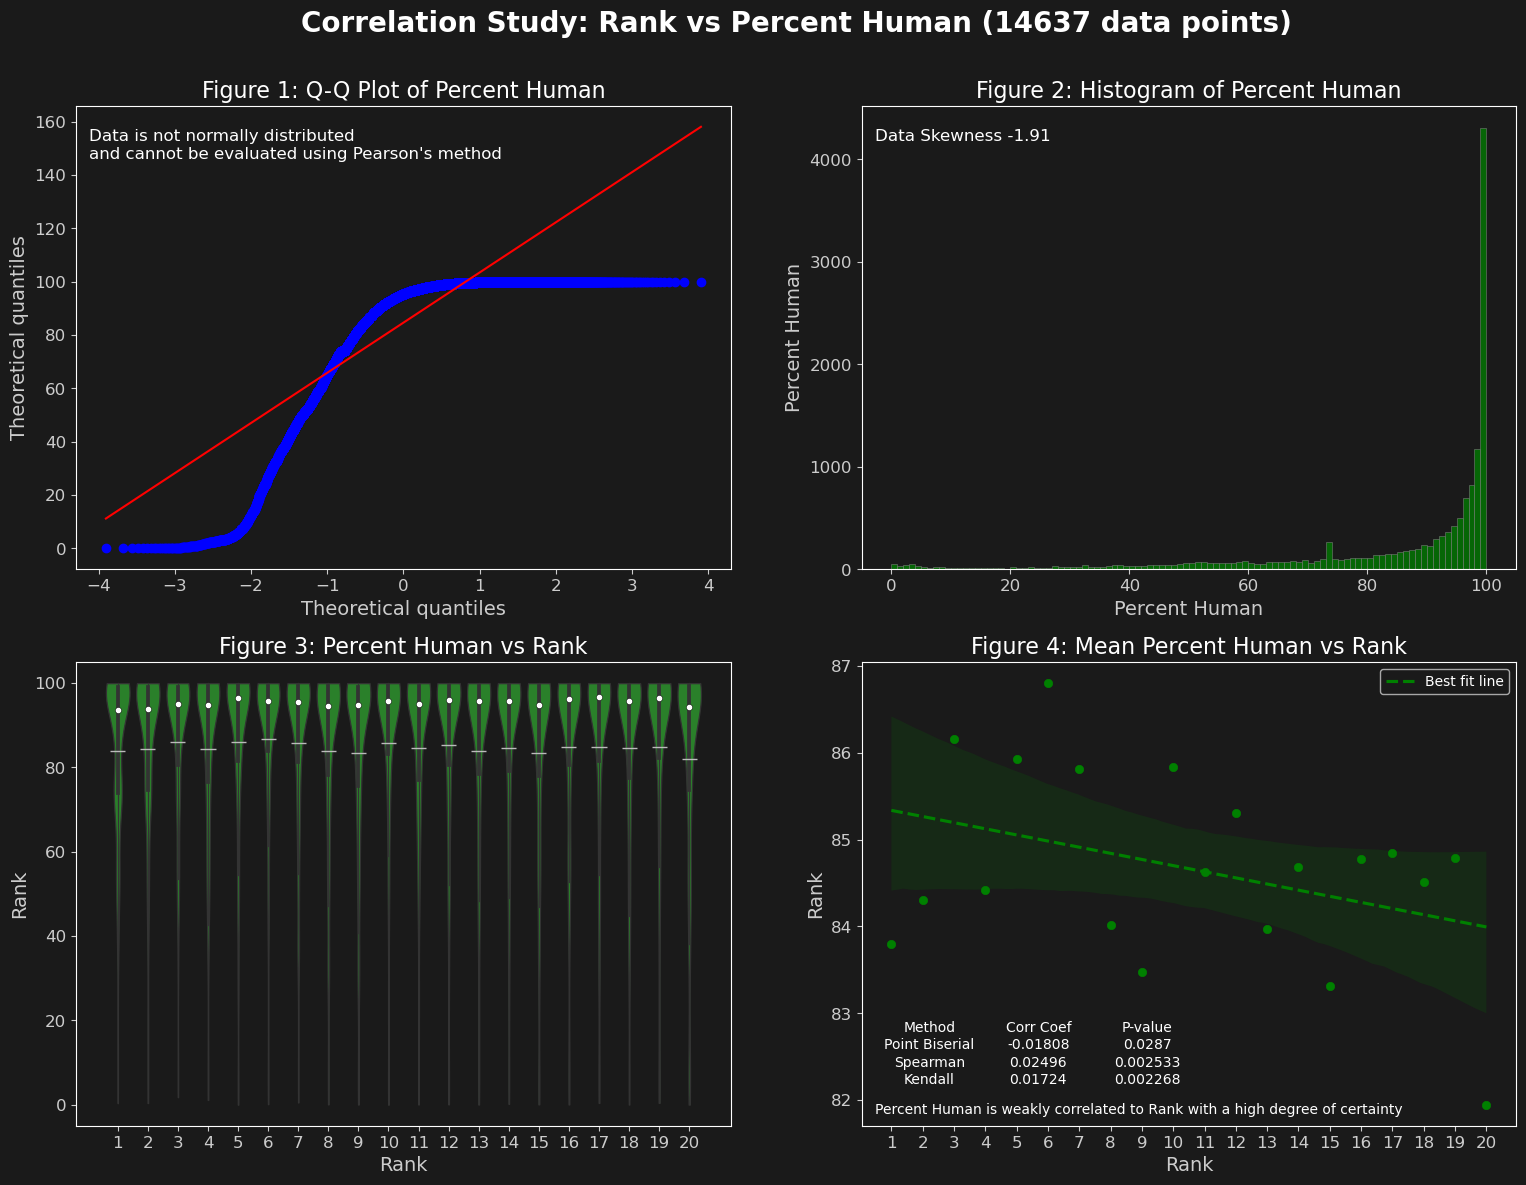

In [6]:
multiplotv_dark(df)

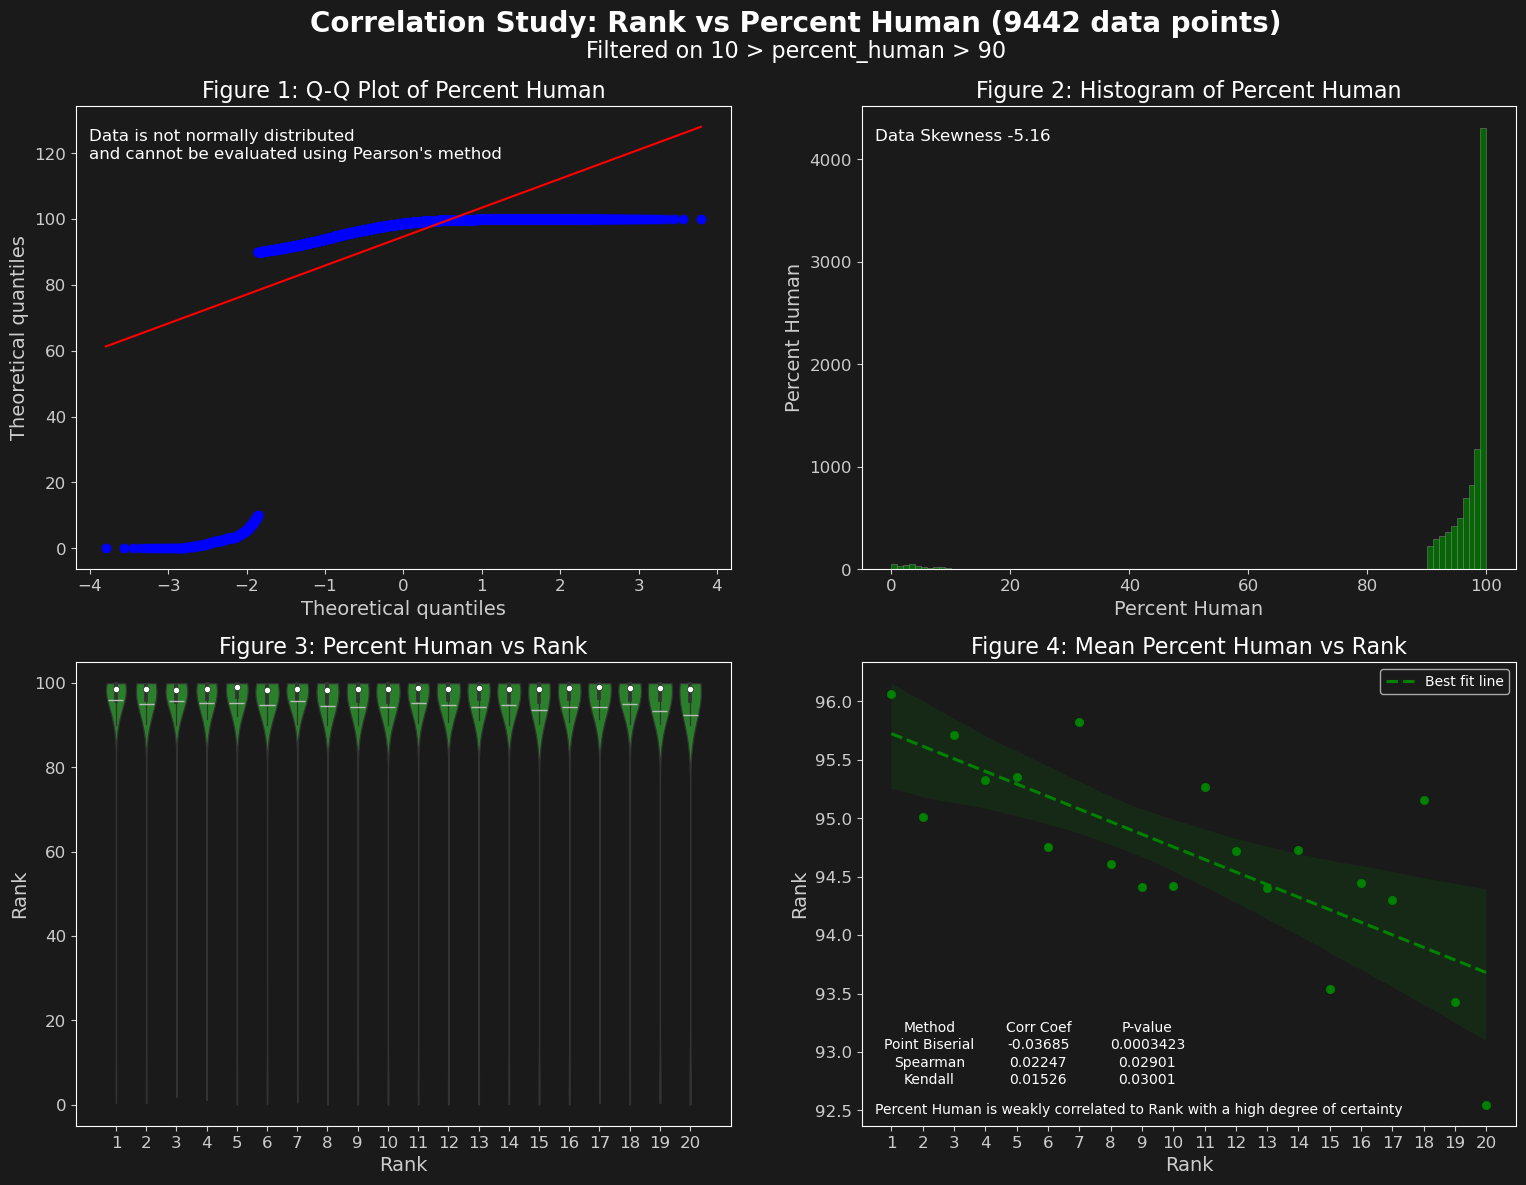

In [7]:
multiplotv_dark(df, 'percent_human', 90, 10)

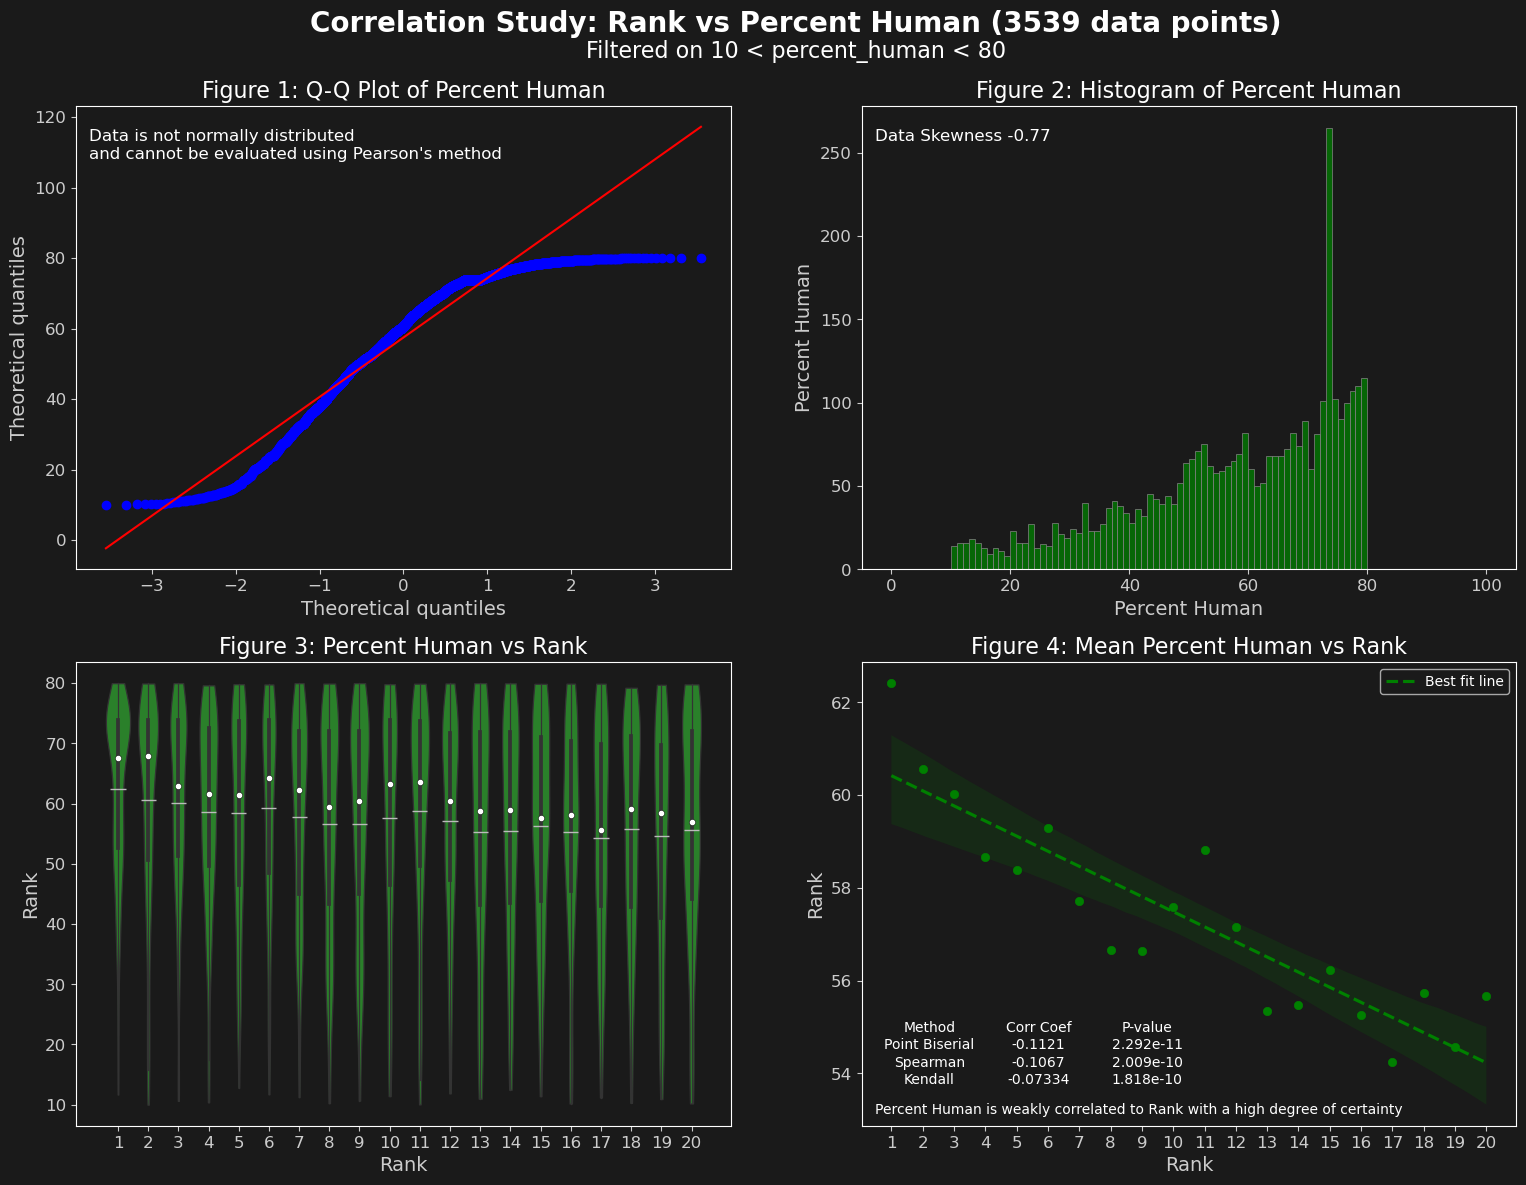

In [8]:
multiplotv_dark(df, 'percent_human', 10, 80)

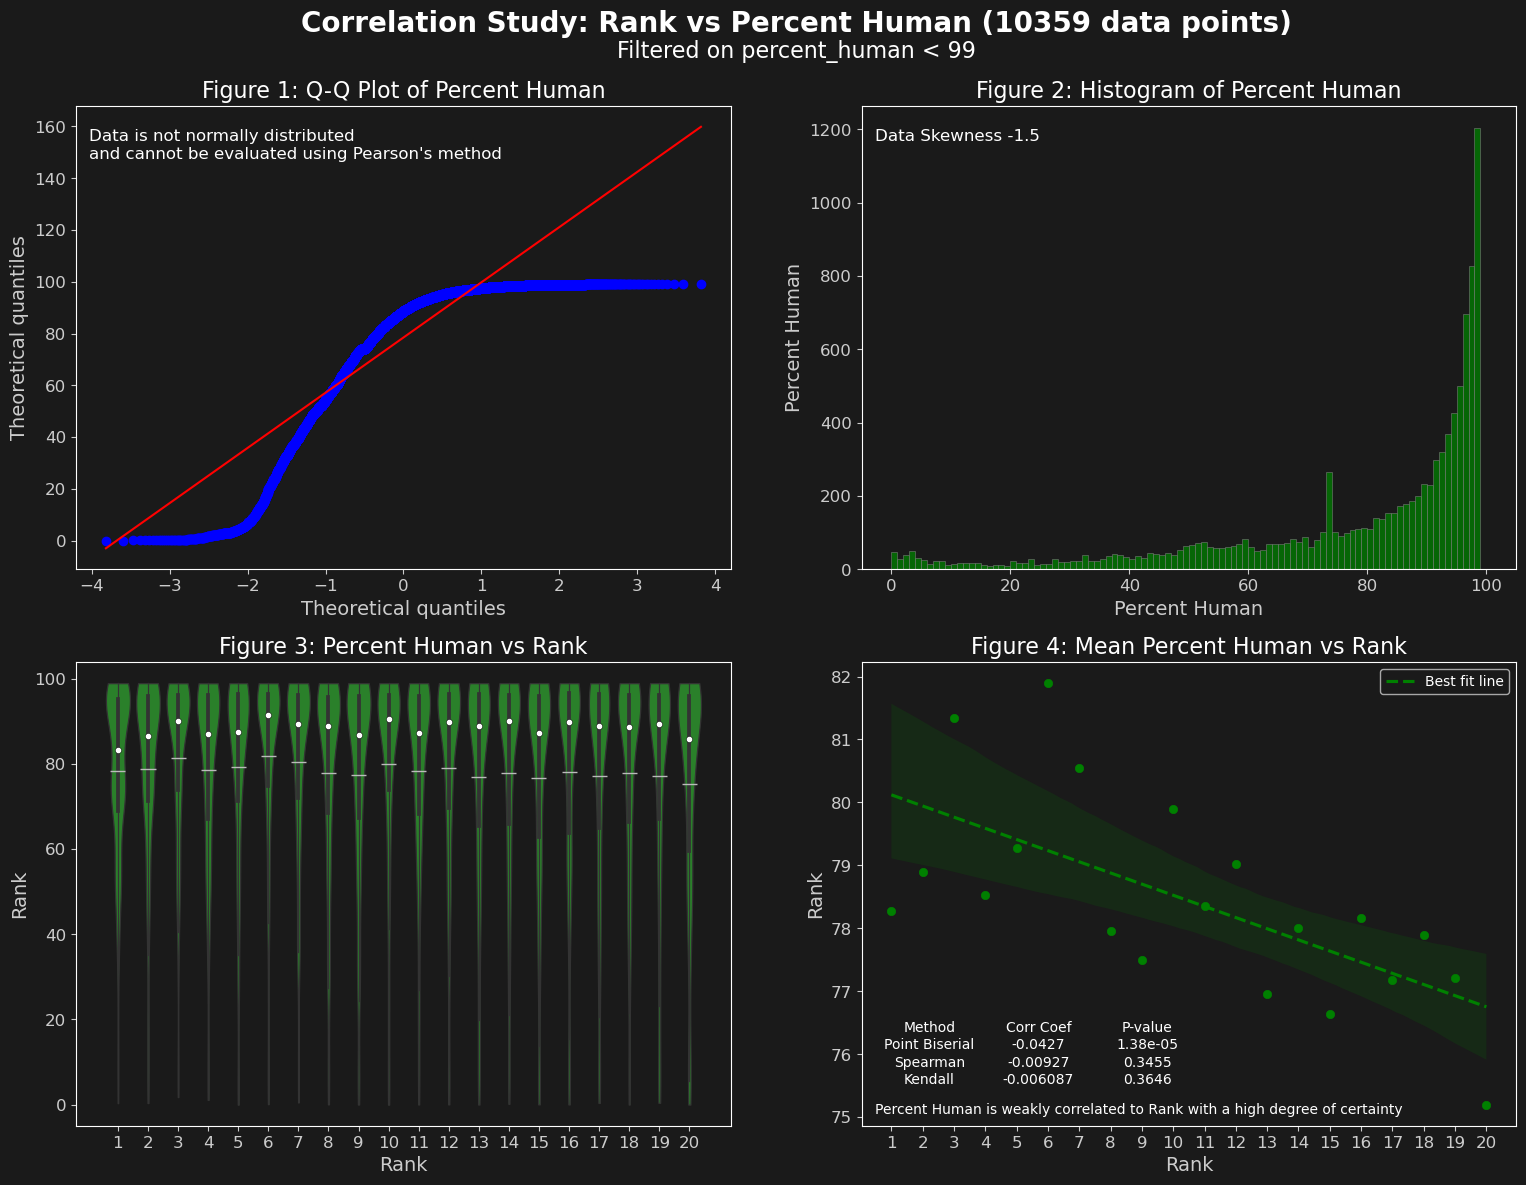

In [23]:
multiplotv_dark(df, 'percent_human', fmax=99)

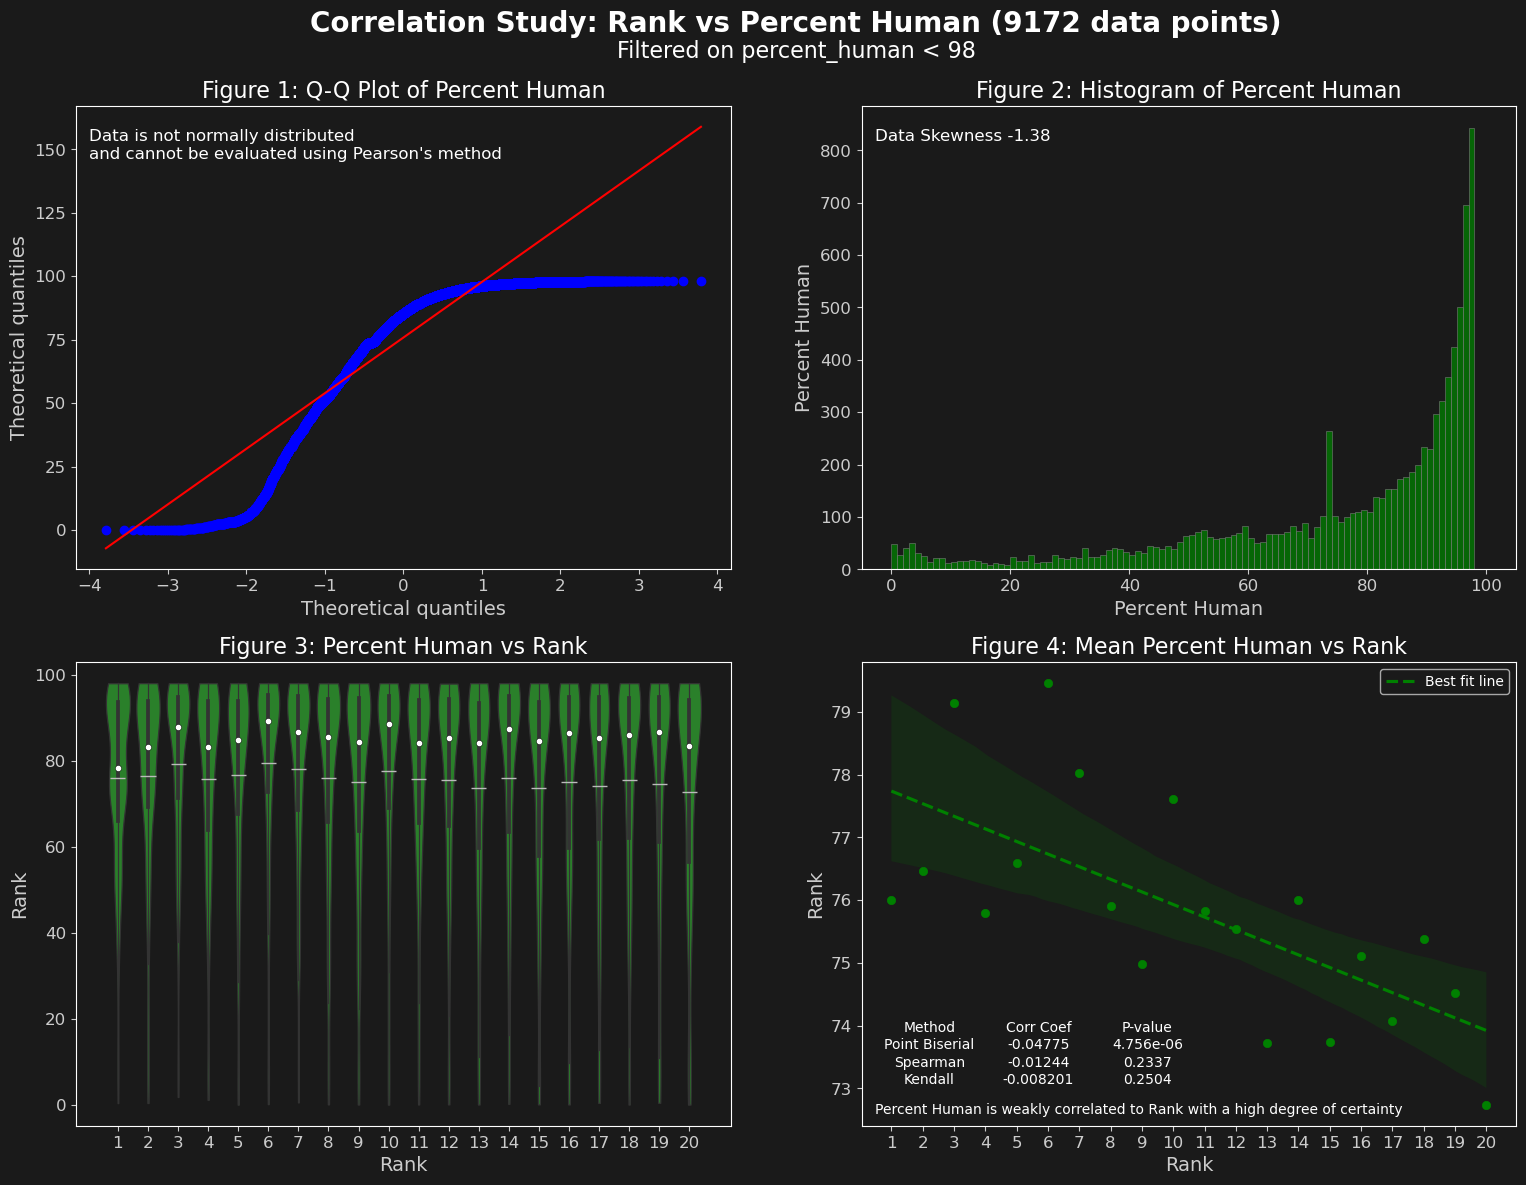

In [24]:
multiplotv_dark(df, 'percent_human', fmax=98)

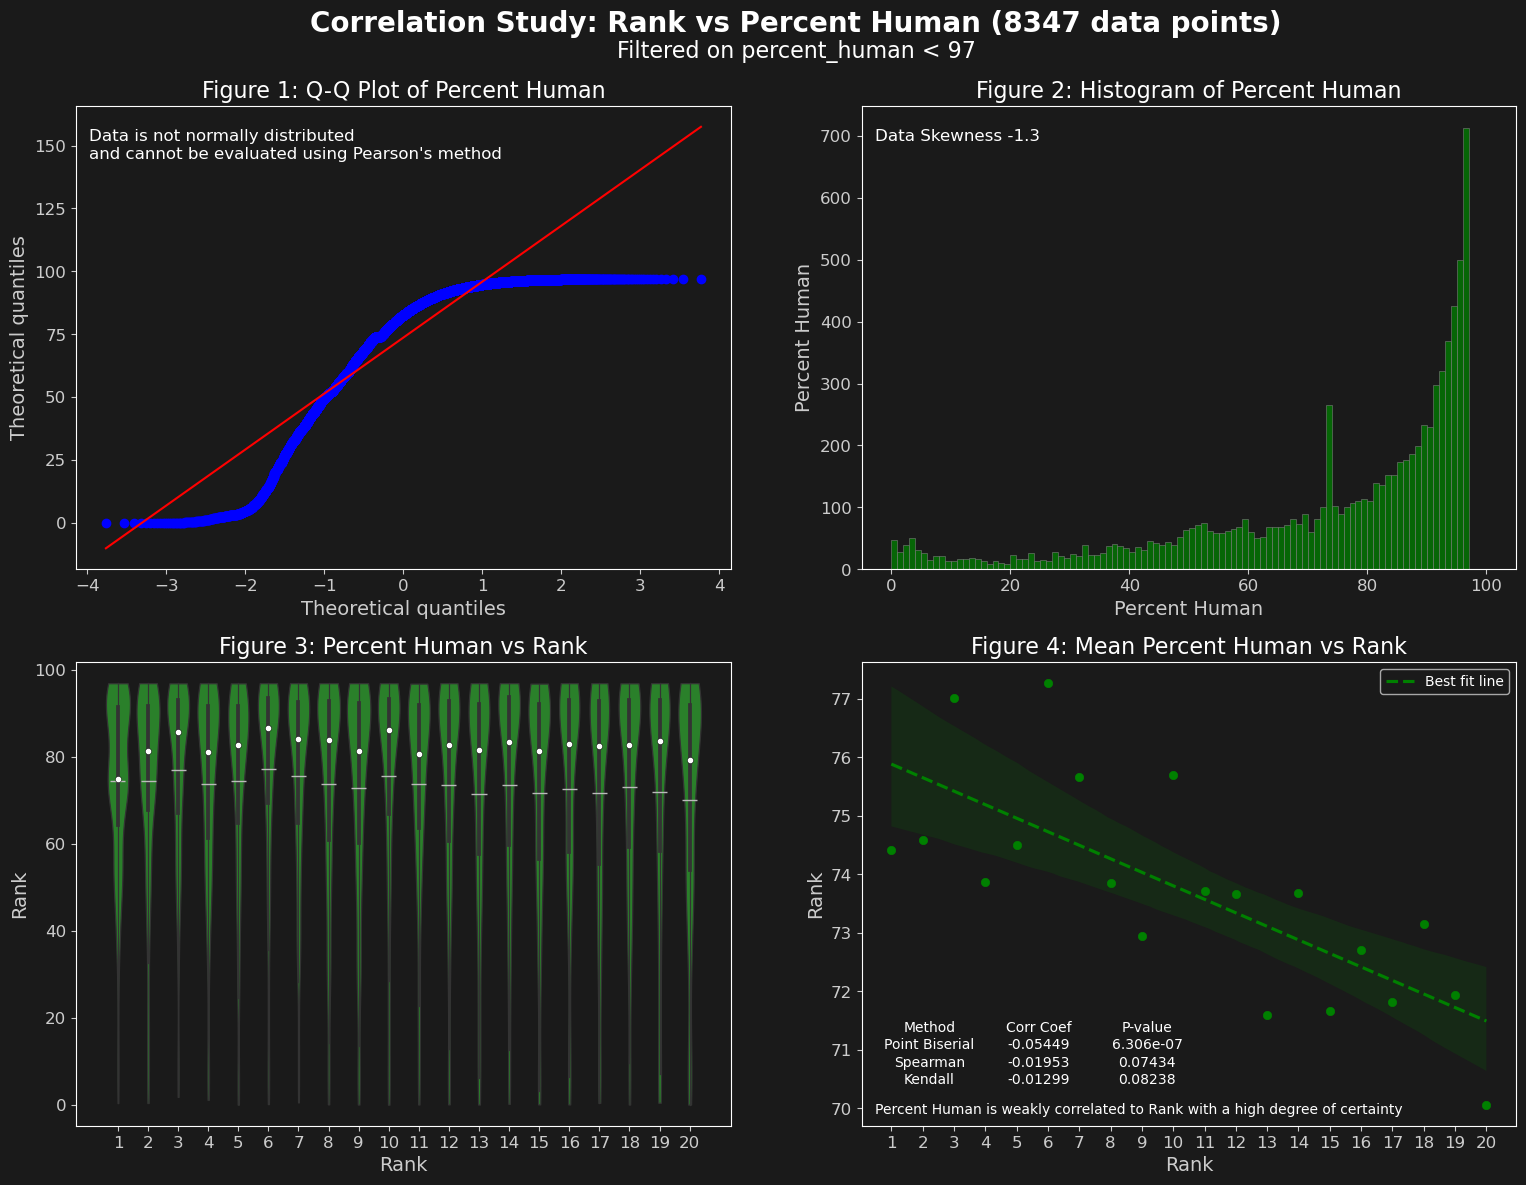

In [25]:
multiplotv_dark(df, 'percent_human', fmax=97)

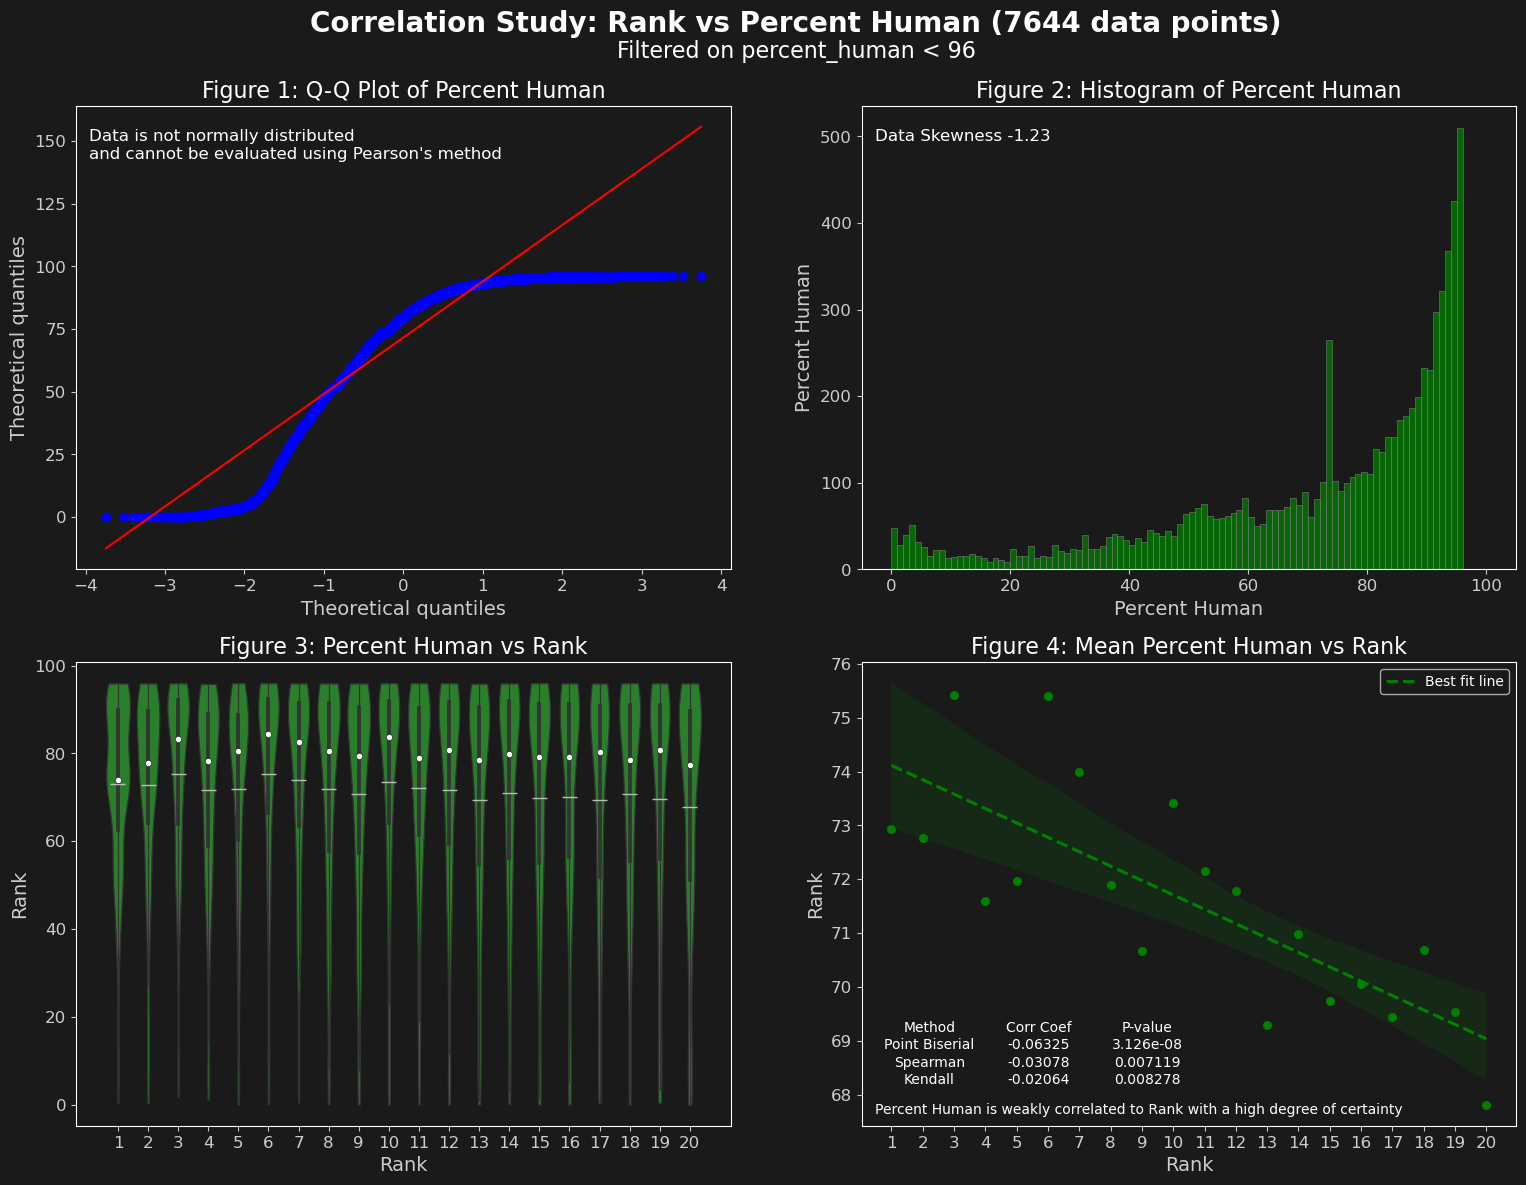

In [26]:
multiplotv_dark(df, 'percent_human', fmax=96)

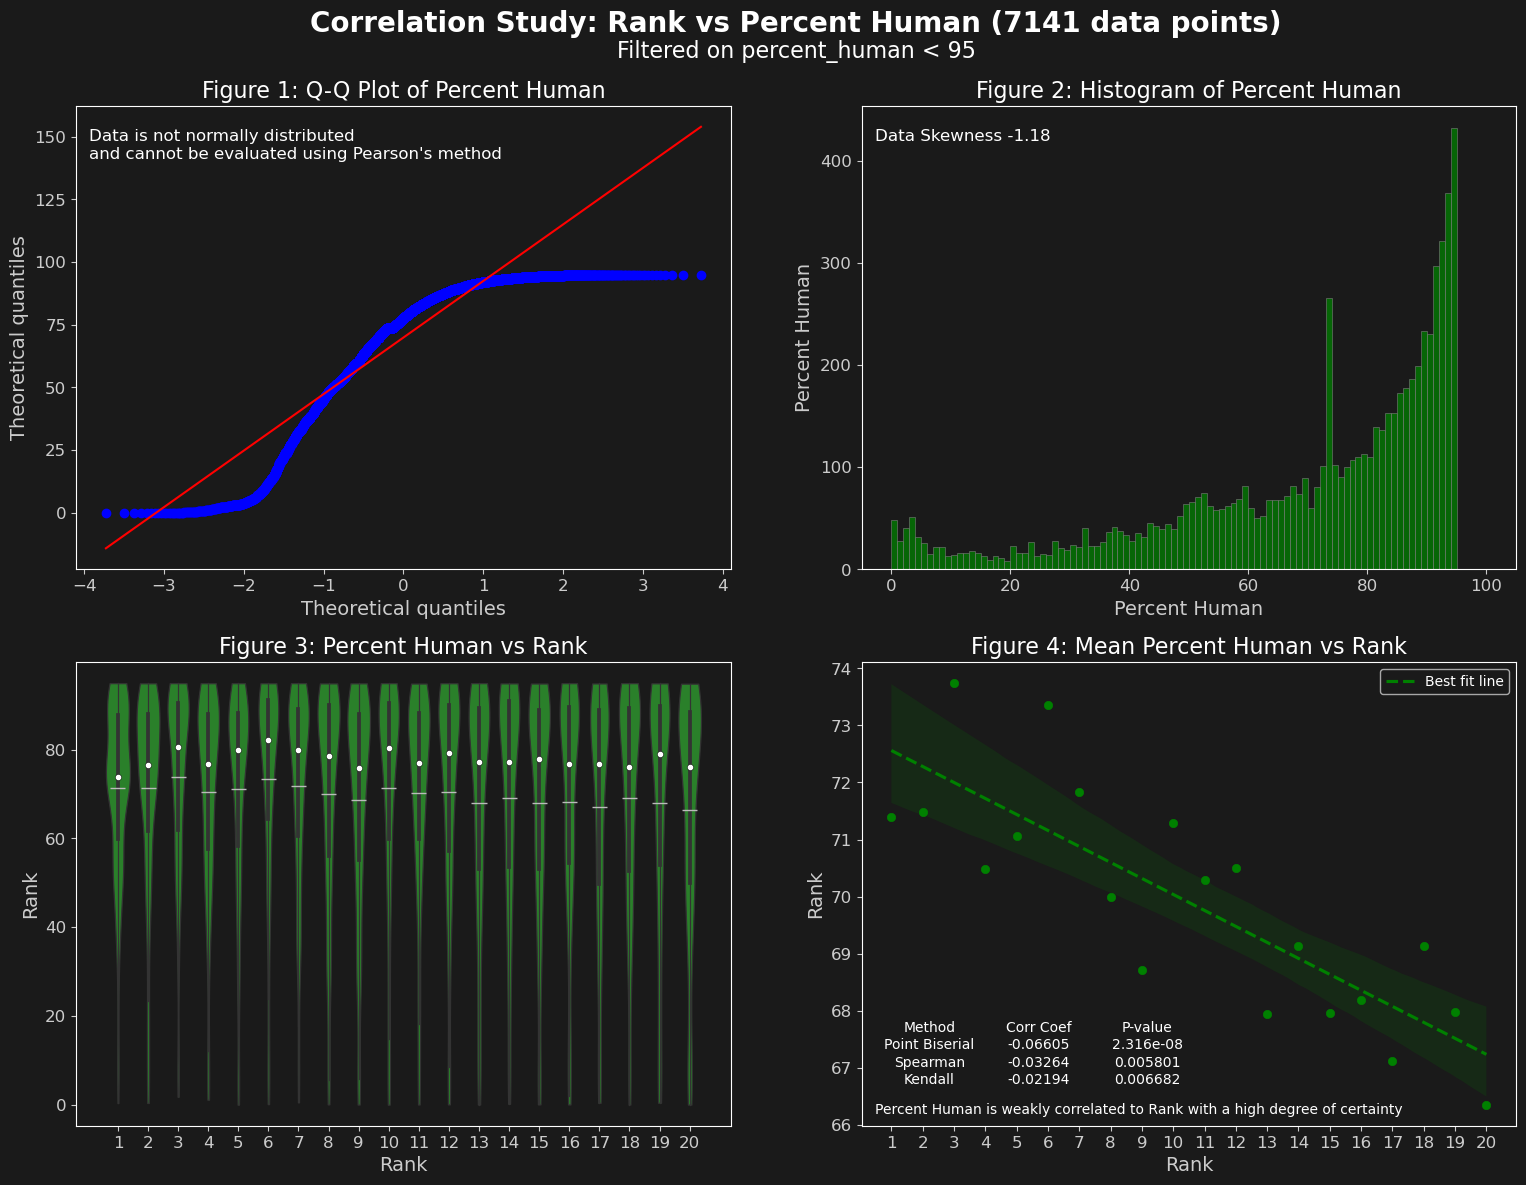

In [27]:
multiplotv_dark(df, 'percent_human', fmax=95)

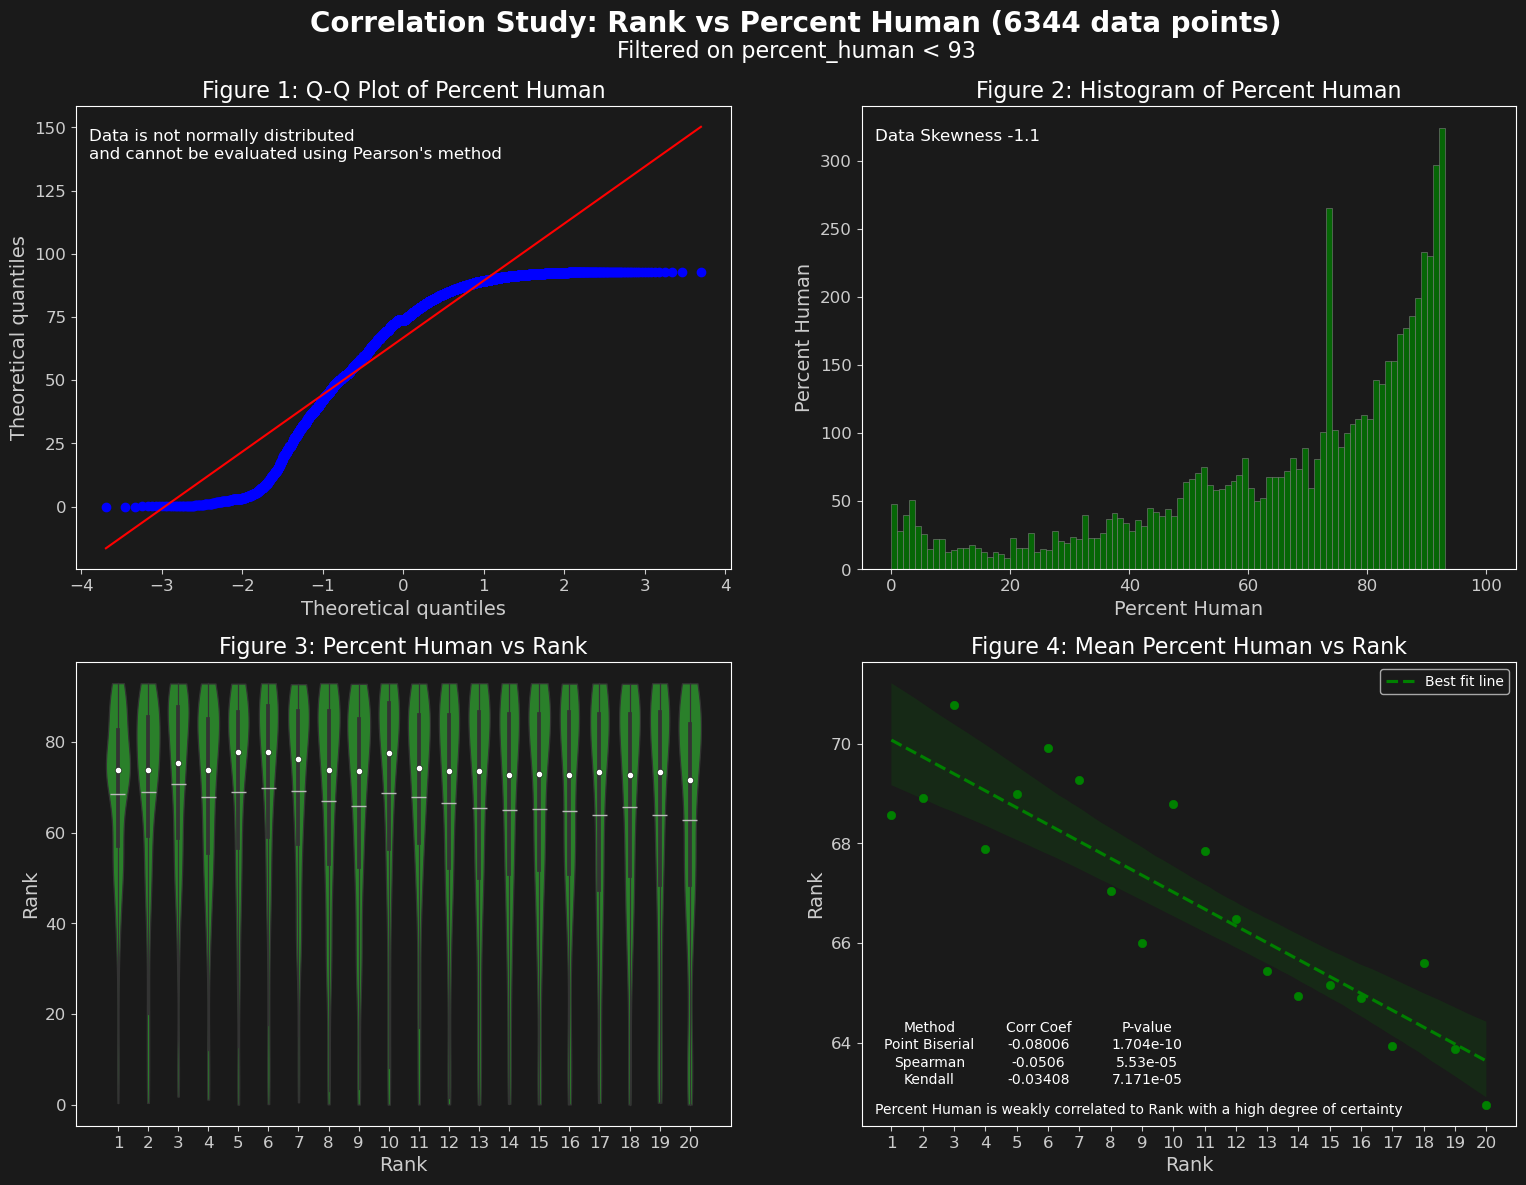

In [28]:
multiplotv_dark(df, 'percent_human', fmax=93)

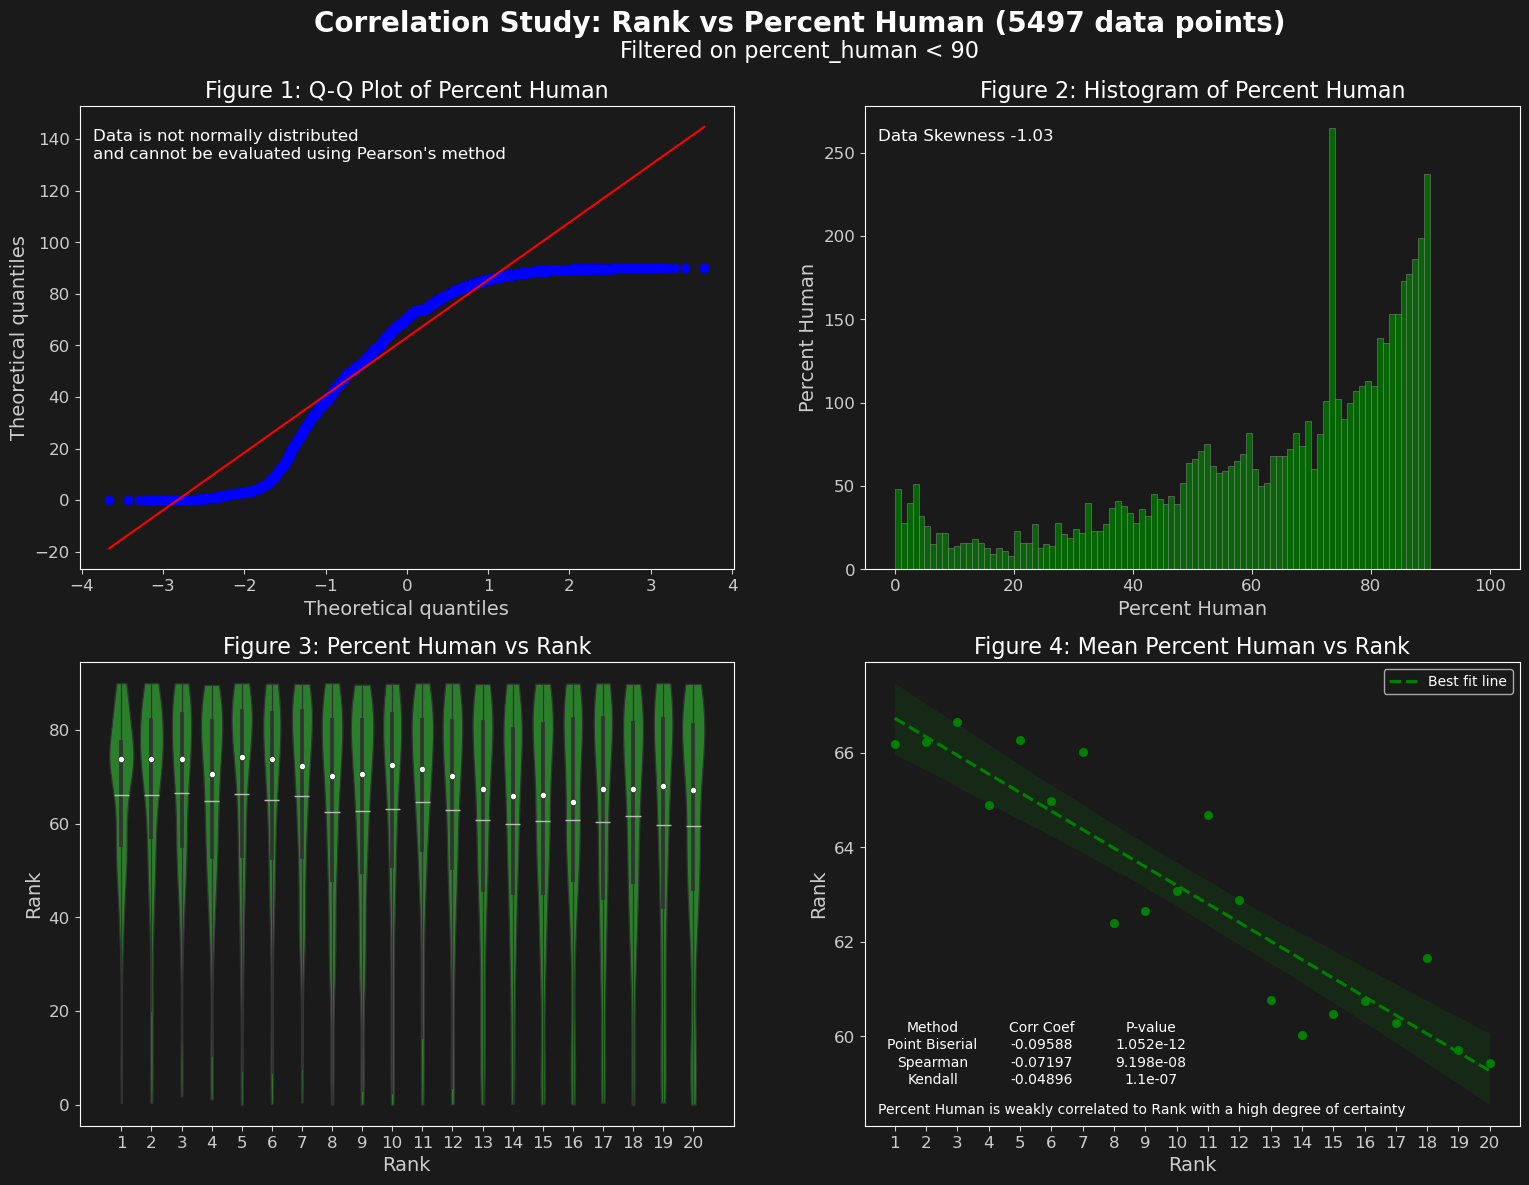

In [29]:
multiplotv_dark(df, 'percent_human', fmax=90)

In [30]:
# try cube roots

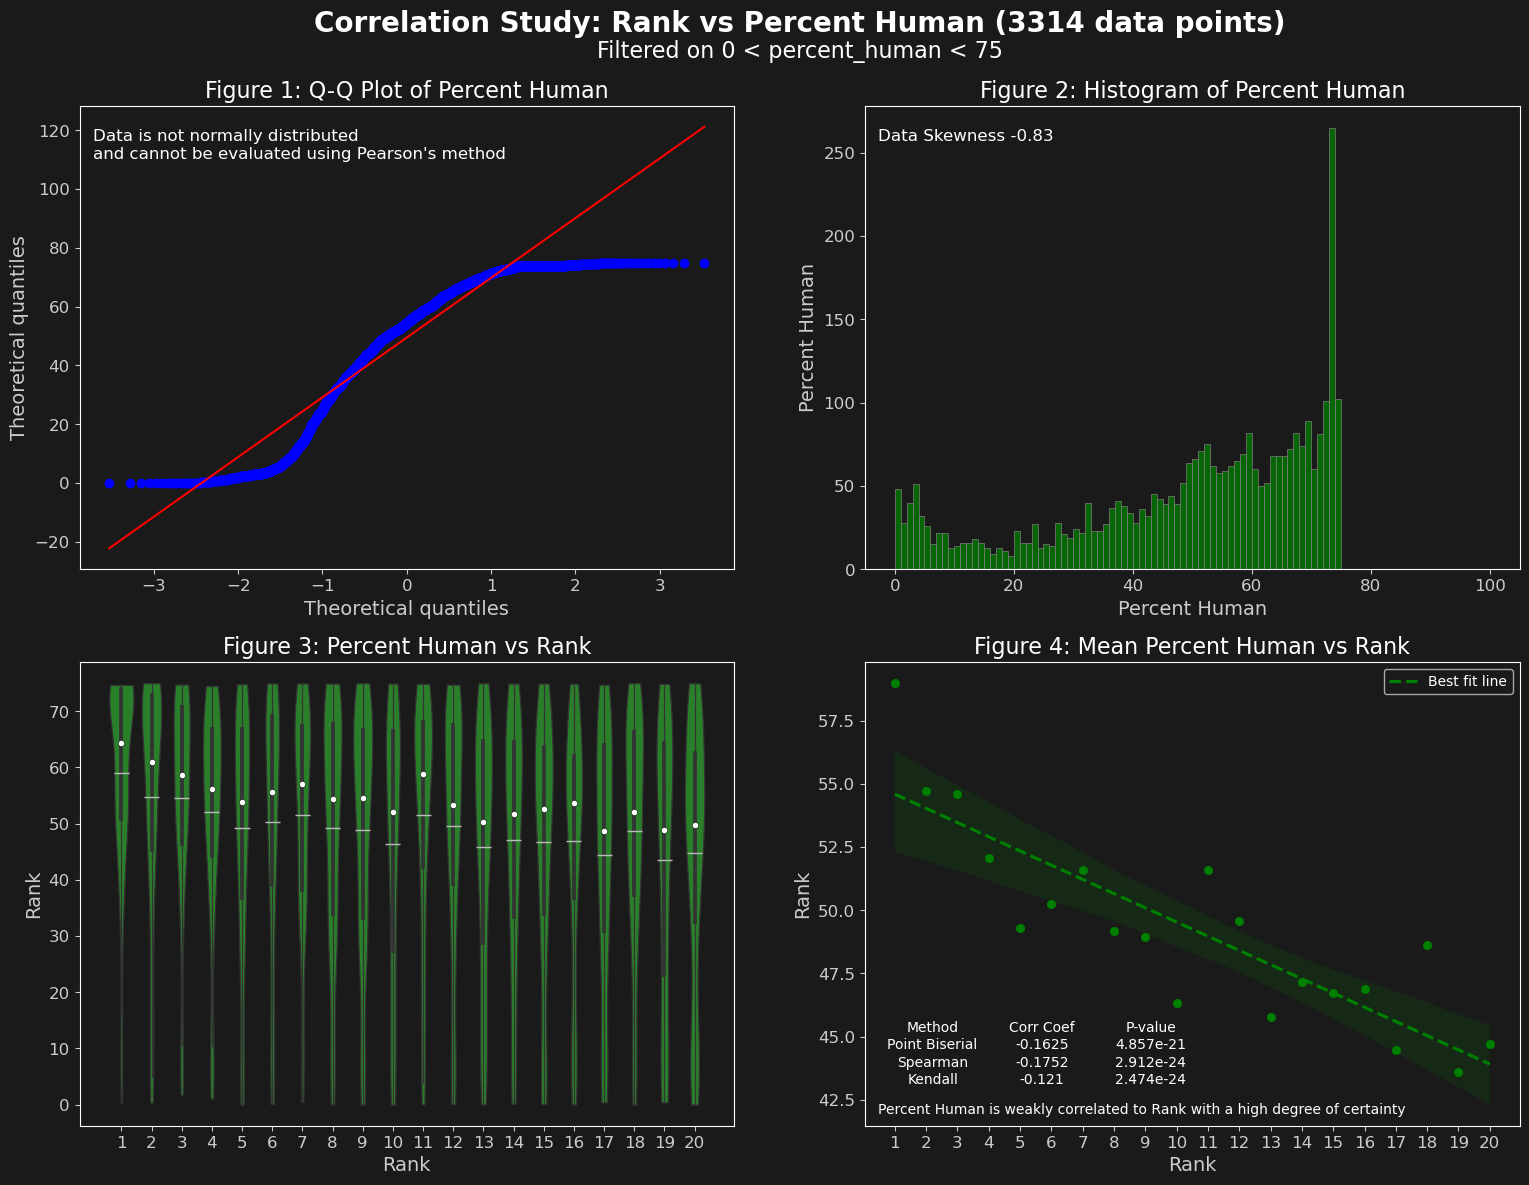

In [31]:
multiplotv_dark(df, 'percent_human', 0, fmax=75)

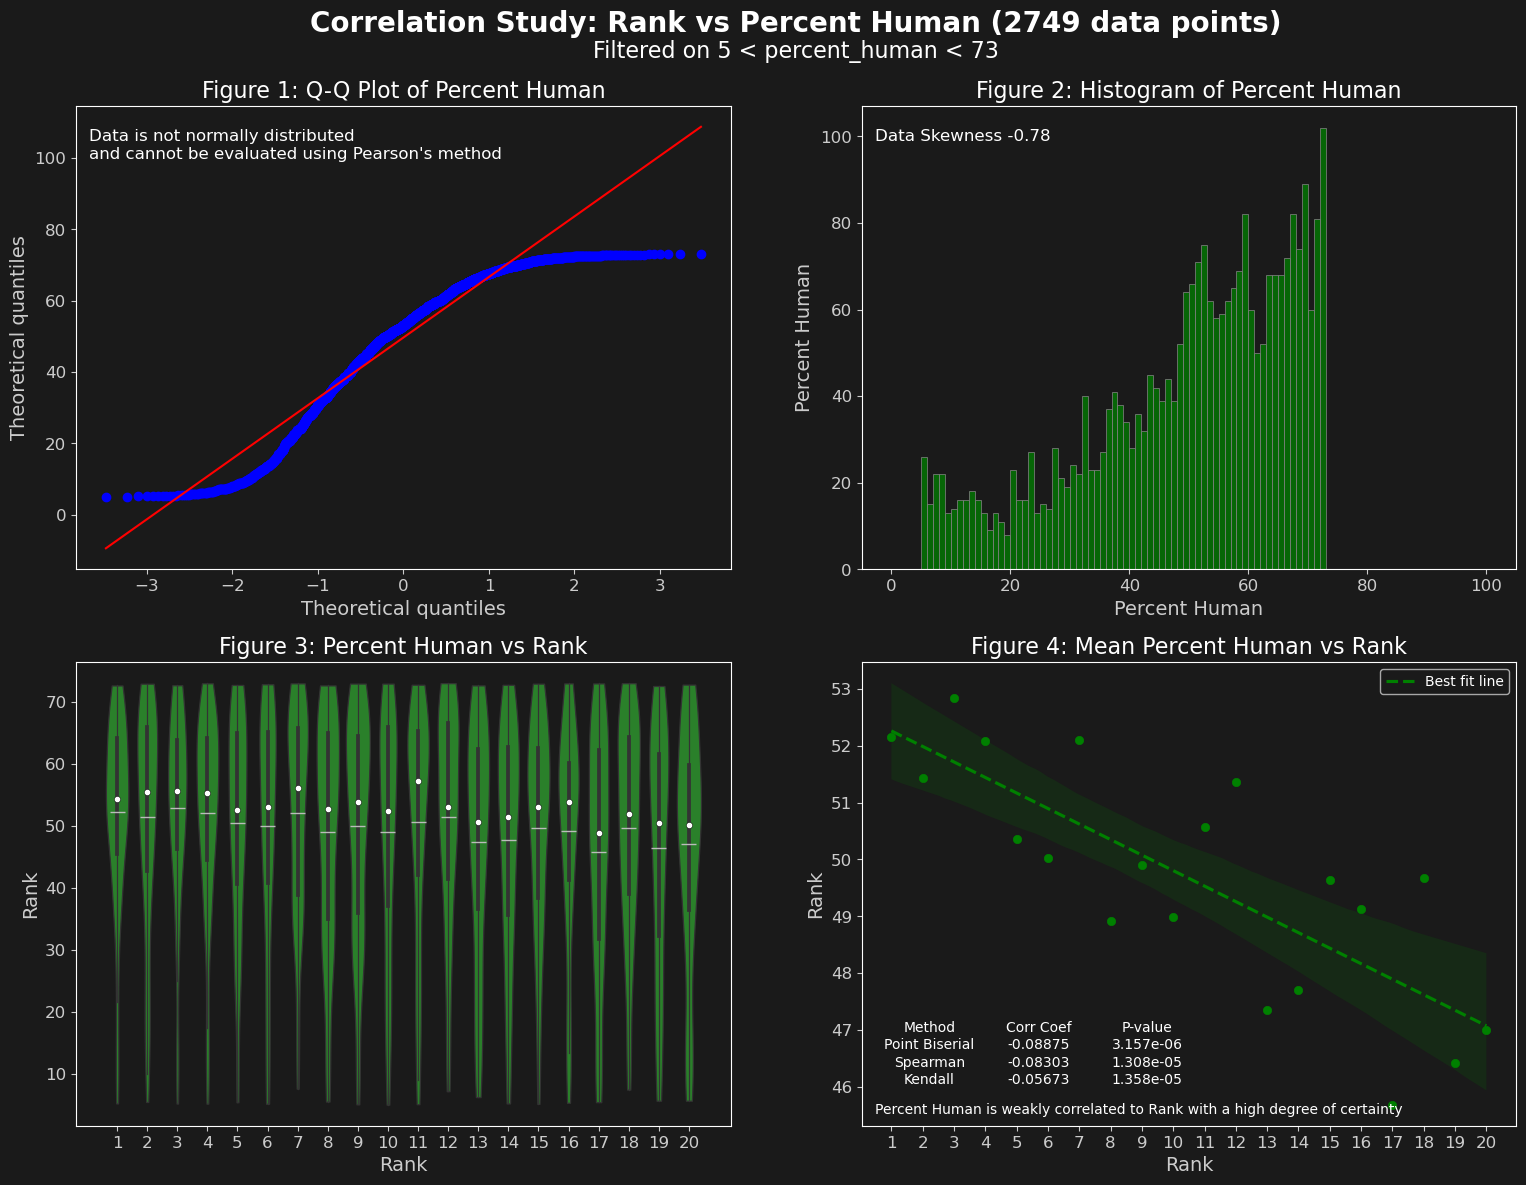

In [32]:
multiplotv_dark(df, 'percent_human', 5, fmax=73)

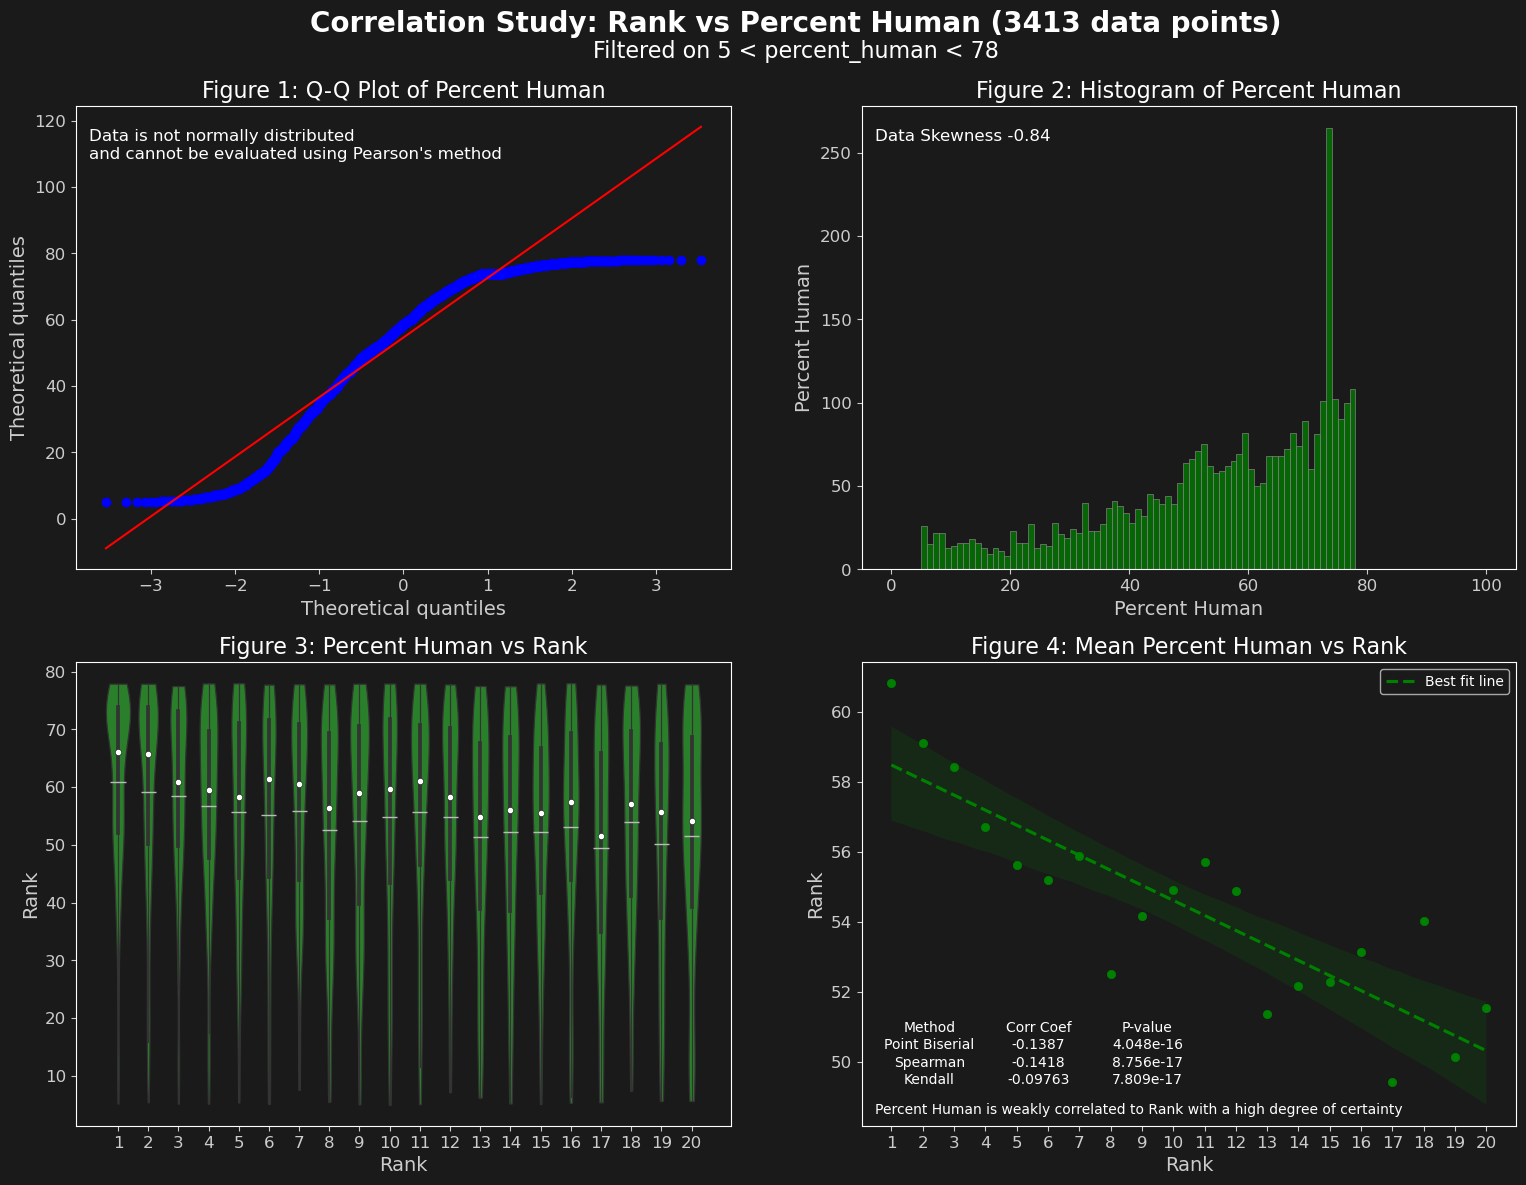

In [33]:
multiplotv_dark(df, 'percent_human', 5, fmax=78)

In [34]:
# one hot Encoding

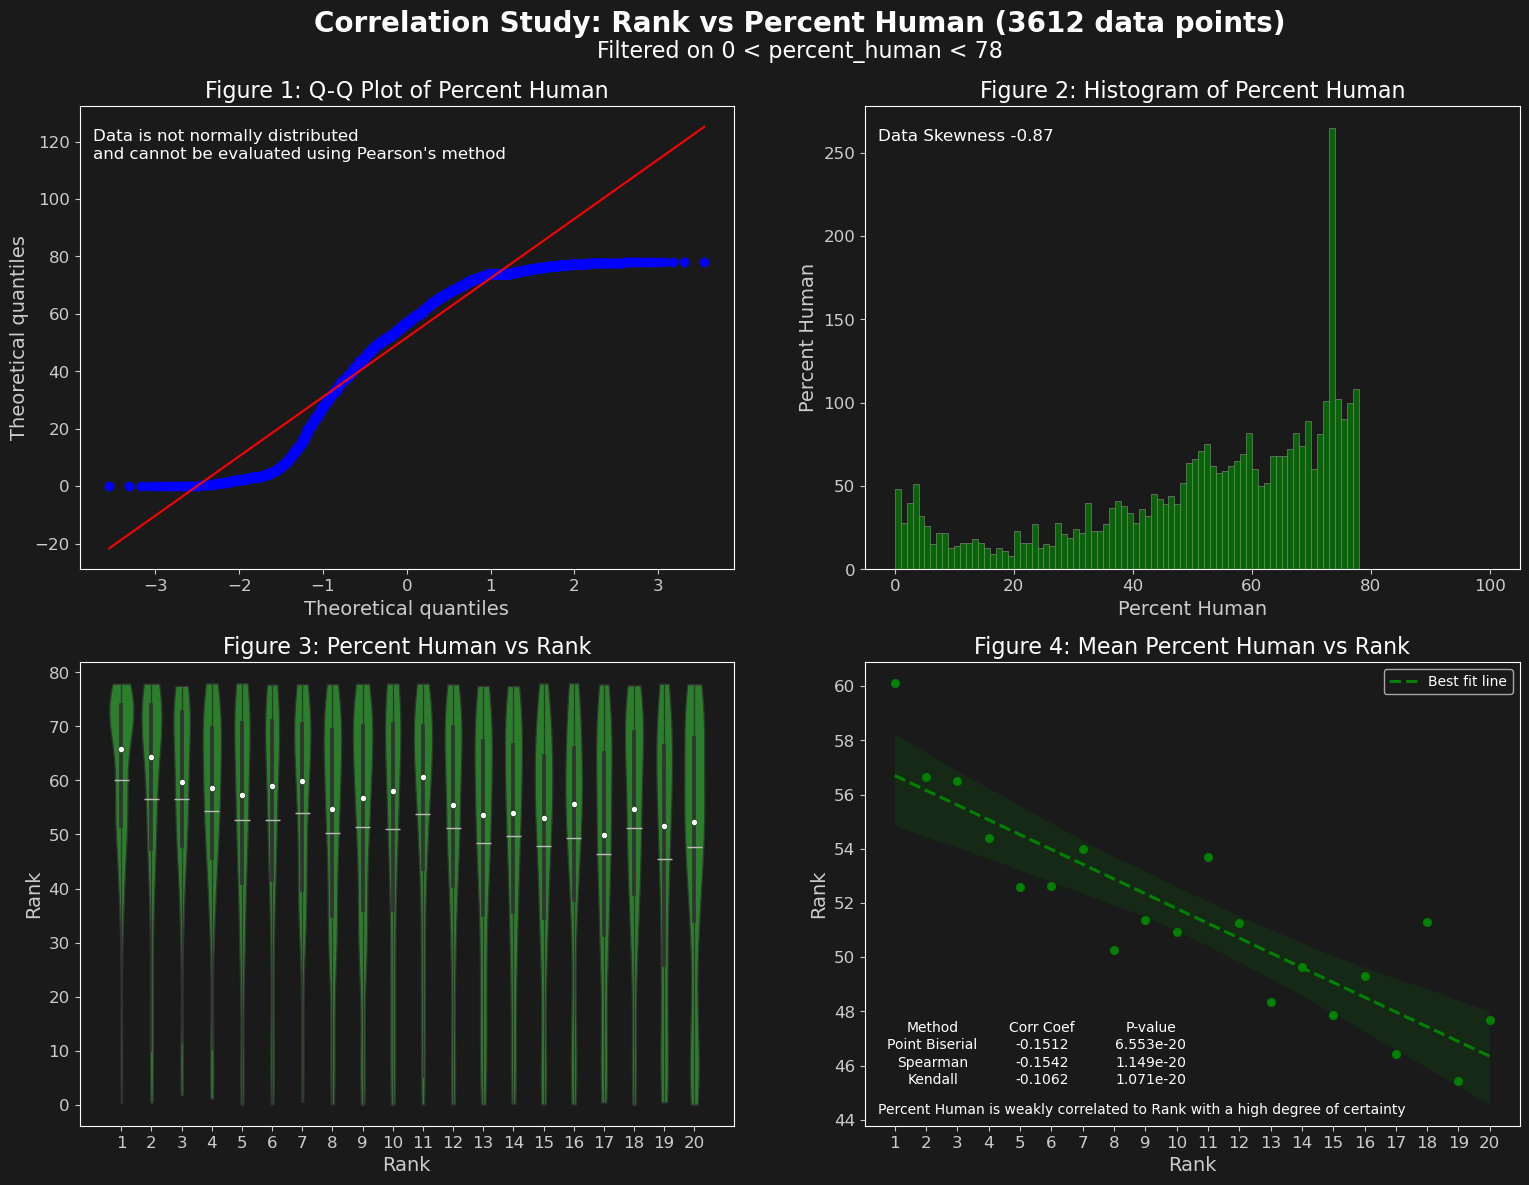

In [35]:
multiplotv_dark(df, 'percent_human', 0, fmax=78)